In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import plotly.express as px

<h3>Preprocessing (Loading, removing and showing graphs)</h3>

In [3]:
# Load your CSV dataset (replace 'your_dataset.csv' with your actual dataset)
df = pd.read_csv('/content/drive/MyDrive/ML/Thesis/Dataset/AU-PEMal-2025-V2.csv')

In [4]:
df.head()

,sha1,processes_malicious,processes_monitored,processes_suspicious,total_procsses,files_malicious,files_suspicious,files_unknown,files_text,registry_total,...,text_PointerToRawData,BaseOfCode,BaseOfData,ImageBase,Checksum,SectionAlignment,SizeOfHeaders,Class,Category,Family
0,62f4d55a1bb8396e493d7815dc44febed7161535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1024,4096,16384,5368709120,125136,4096,1024,Benign,Benign,Benign
1,ca40945a4e35d48794a5e13aacf16b8ae1caddeb,0.0,2.0,0.0,93.0,0.0,0.0,0.0,0.0,5.0,...,1024,4096,16384,5368709120,5202495,4096,1024,Benign,Benign,Benign
2,6f47b50480bea61ae4dfb75c12582990cc5ce770,0.0,1.0,0.0,35.0,0.0,0.0,0.0,0.0,58.0,...,512,8192,16384,4194304,0,8192,512,Benign,Benign,Benign
3,8c3d5b506a8d55f42f4c83ead3e4341255d1acfc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1536,4096,16384,4194304,0,4096,1536,Benign,Benign,Benign
4,0a7d0c68c591db2f197b2169d226bebe6e9bdabe,0.0,1.0,0.0,36.0,0.0,0.0,0.0,0.0,253.0,...,512,8192,0,4194304,0,8192,512,Benign,Benign,Benign


In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.shape

(21703, 39)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21703 entries, 0 to 21702
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sha1                     21703 non-null  object 
 1   processes_malicious      21703 non-null  float64
 2   processes_monitored      21703 non-null  float64
 3   processes_suspicious     21703 non-null  float64
 4   total_procsses           21703 non-null  float64
 5   files_malicious          21703 non-null  float64
 6   files_suspicious         21703 non-null  float64
 7   files_unknown            21703 non-null  float64
 8   files_text               21703 non-null  float64
 9   registry_total           21703 non-null  float64
 10  registry_read            21703 non-null  float64
 11  registry_write           21703 non-null  float64
 12  registry_delete          21703 non-null  float64
 13  network_dns              21703 non-null  float64
 14  network_http          

In [8]:
df = df.drop(['sha1','Family', 'Class'], axis=1)
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns =[ 'Category']
df = pd.DataFrame(df)

In [9]:
from sklearn.preprocessing import LabelEncoder
# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [10]:
df.isnull().sum()

,0
processes_malicious,0
processes_monitored,0
processes_suspicious,0
total_procsses,0
files_malicious,0
files_suspicious,0
files_unknown,0
files_text,0
registry_total,0
registry_read,0


##Outliers ##

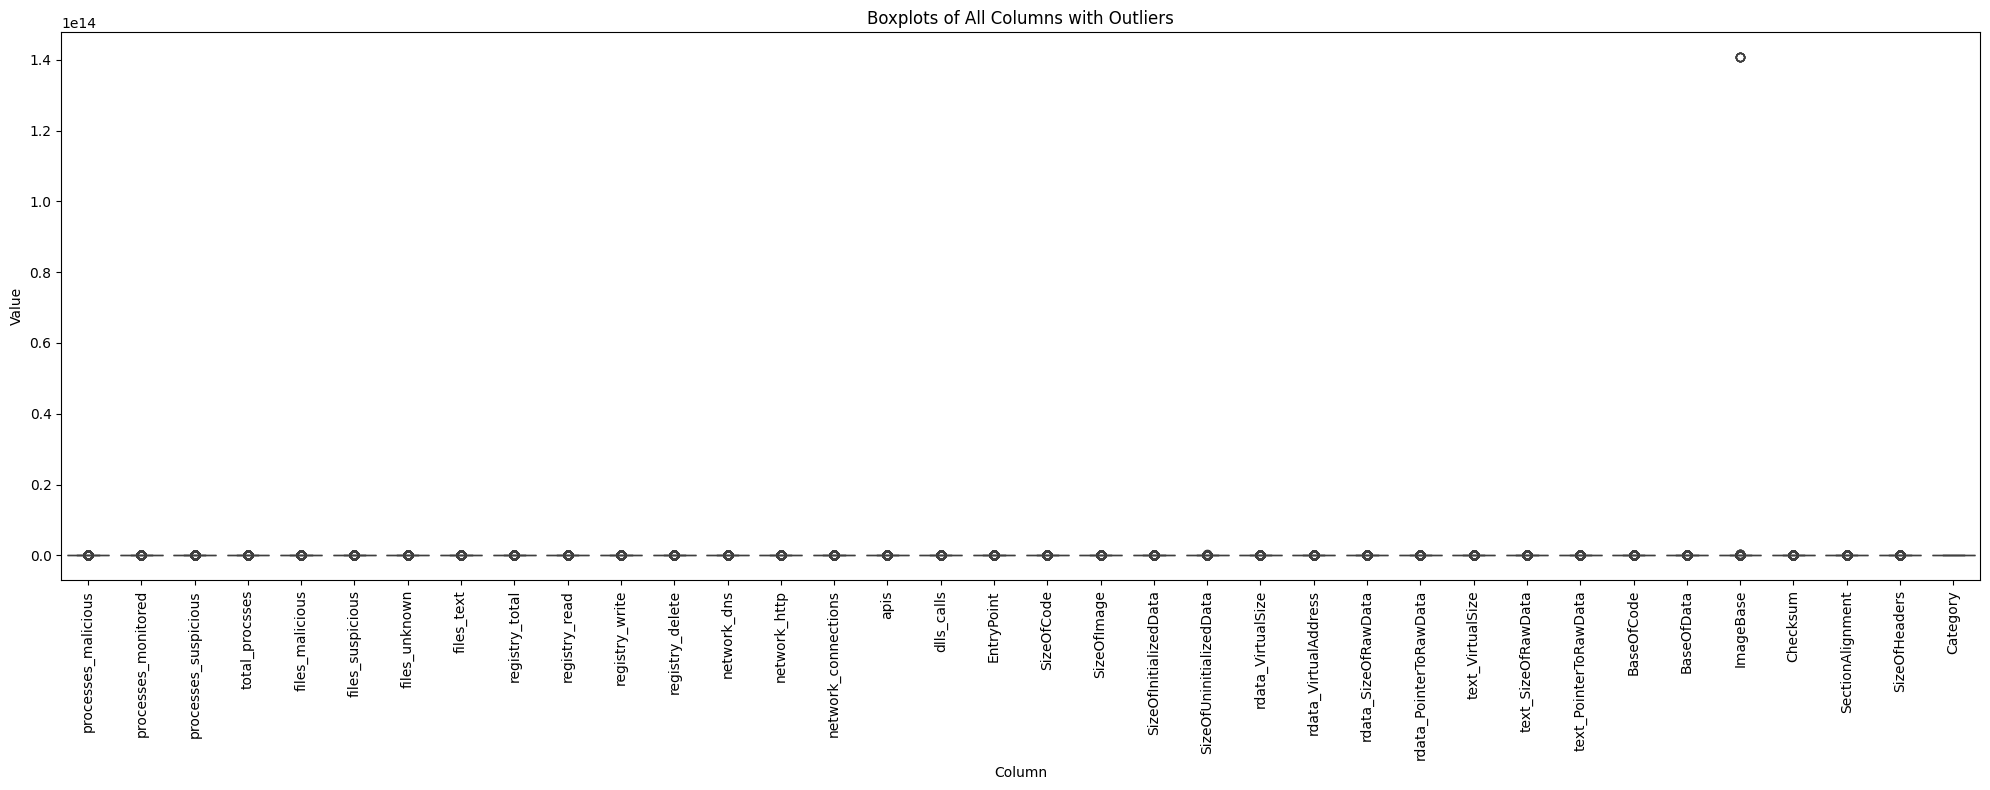

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert wide df (55 columns) into long format
df_melted = df.melt(var_name="Column", value_name="Value")

plt.figure(figsize=(20, 8))  # wider figure to fit all columns on x-axis
sns.boxplot(x="Column", y="Value", data=df_melted)

plt.xticks(rotation=90)  # rotate labels for readability
plt.title("Boxplots of All Columns with Outliers")
plt.tight_layout()
plt.show()


In [12]:
outliers_per_column = {}
for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outliers_per_column[col] = len(outliers)

In [13]:
outliers_per_column

{'processes_malicious': 1307,
 'processes_monitored': 2860,
 'processes_suspicious': 3061,
 'total_procsses': 3914,
 'files_malicious': 3633,
 'files_suspicious': 4614,
 'files_unknown': 4613,
 'files_text': 4157,
 'registry_total': 2935,
 'registry_read': 2919,
 'registry_write': 4460,
 'registry_delete': 2626,
 'network_dns': 3044,
 'network_http': 4231,
 'network_connections': 1537,
 'apis': 1587,
 'dlls_calls': 862,
 'EntryPoint': 2678,
 'SizeOfCode': 2503,
 'SizeOfImage': 3251,
 'SizeOfInitializedData': 3691,
 'SizeOfUninitializedData': 2114,
 'rdata_VirtualSize': 3650,
 'rdata_VirtualAddress': 3115,
 'rdata_SizeOfRawData': 3490,
 'rdata_PointerToRawData': 3039,
 'text_VirtualSize': 2467,
 'text_SizeOfRawData': 2701,
 'text_PointerToRawData': 10388,
 'BaseOfCode': 3034,
 'BaseOfData': 2757,
 'ImageBase': 4326,
 'Checksum': 3618,
 'SectionAlignment': 2084,
 'SizeOfHeaders': 8933,
 'Category': 0}

In [14]:
#Cap Outliers (Winsorize / Clipping Approach)
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower, lower,
                 np.where(df[column] > upper, upper, df[column]))
    return df

# Apply to columns with outliers
for col, count in outliers_per_column.items():
    if count > 0:
        df = cap_outliers_iqr(df, col)

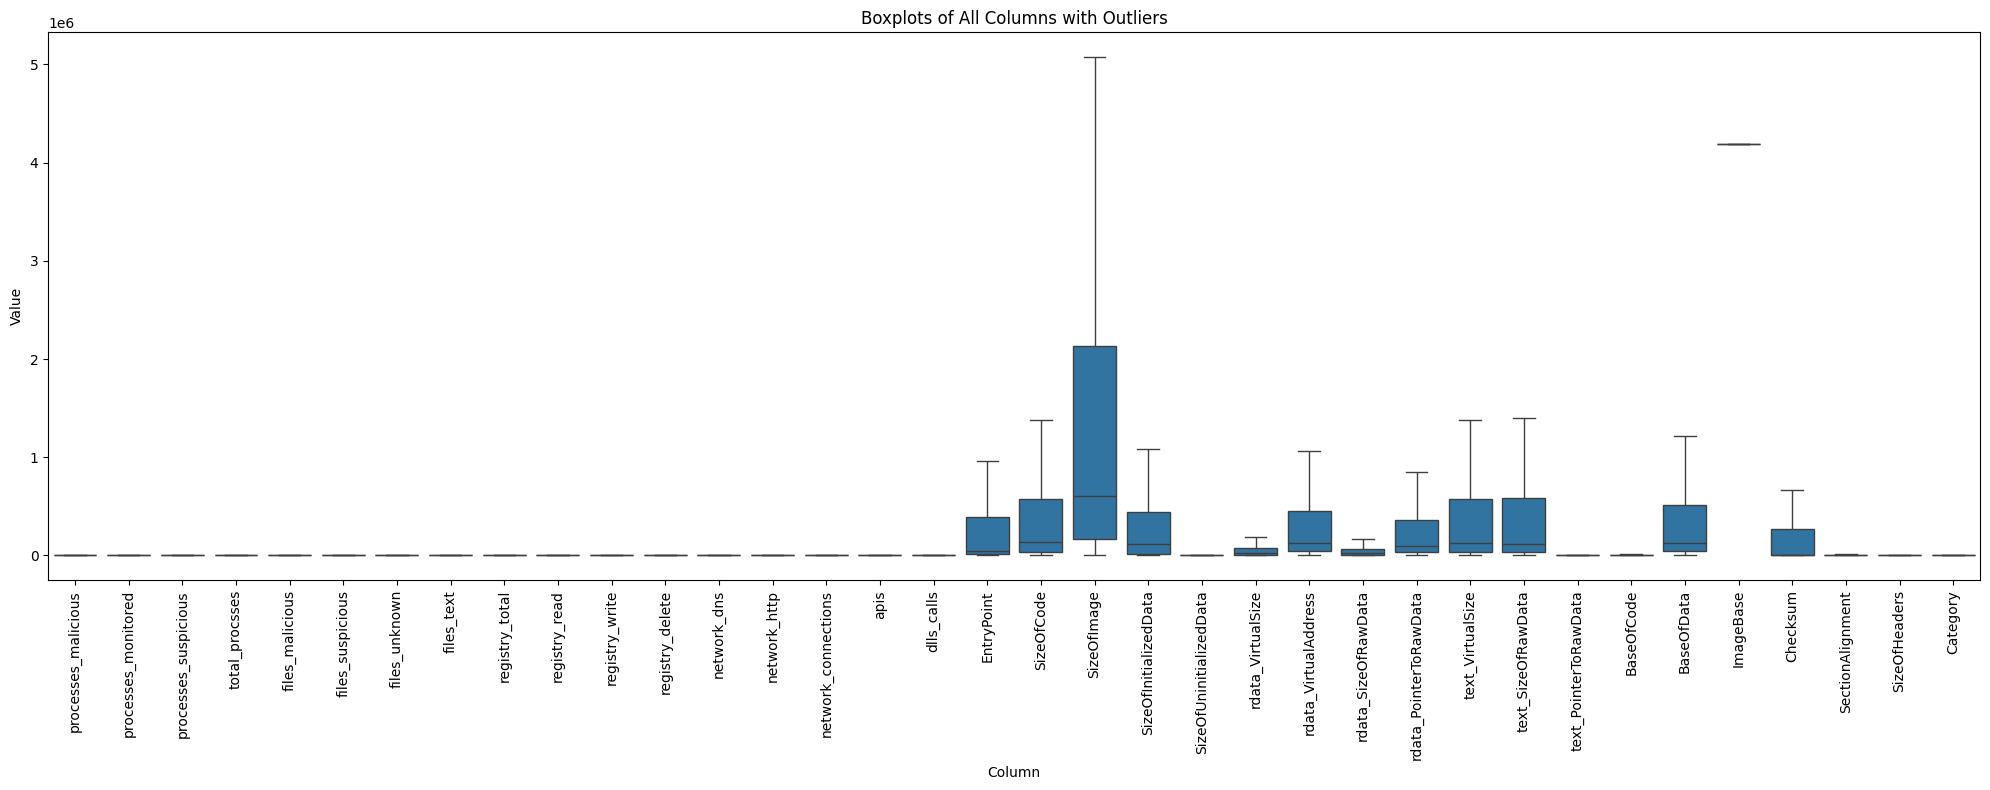

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert wide df (55 columns) into long format
df_melted = df.melt(var_name="Column", value_name="Value")

plt.figure(figsize=(20, 8))  # wider figure to fit all columns on x-axis
sns.boxplot(x="Column", y="Value", data=df_melted)

plt.xticks(rotation=90)  # rotate labels for readability
plt.title("Boxplots of All Columns with Outliers")
plt.tight_layout()
plt.show()


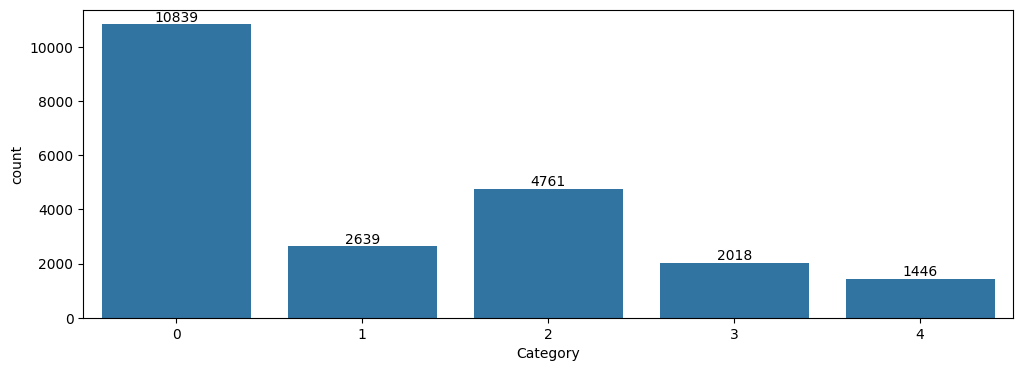

In [16]:
plt.figure(figsize=(12,4))
ax = sns.countplot(x='Category',data=df)
for i in ax.containers:
    ax.bar_label(i,)

<h3>Normalization</h3>

In [17]:
from sklearn.preprocessing import StandardScaler
# Create a Min-Max scaler instance
scaler = StandardScaler()
# Select the columns you want to scale (exclude the target variable if needed)
columns_to_scale = df.columns  # You can select specific columns here

# Fit the scaler on the selected columns and transform the data
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

<h3>Spliting for Training and Testing</h3>

In [18]:
# Separate features and labels
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values   # Class labels
X.shape

(21703, 35)

In [19]:
y.shape

(21703,)

<h3>ML Models Implementation</h3>


🔹 Training Logistic Regression...
Logistic Regression Performance:
  Accuracy:  0.8705
  Precision: 0.8714
  Recall:    0.8705
  F1-score:  0.8709

Classification Report:
               precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      2168
         RAT       0.68      0.68      0.68       528
  Ransomware       0.90      0.90      0.90       952
     Stealer       0.66      0.63      0.64       404
      Trojan       0.54      0.57      0.55       289

    accuracy                           0.87      4341
   macro avg       0.75      0.75      0.75      4341
weighted avg       0.87      0.87      0.87      4341



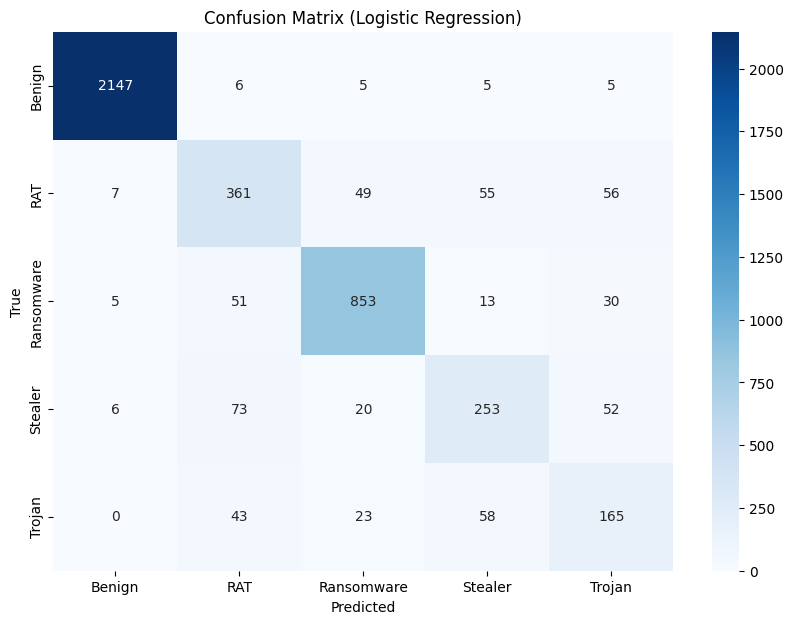


🔹 Training Random Forest...
Random Forest Performance:
  Accuracy:  0.9749
  Precision: 0.9756
  Recall:    0.9749
  F1-score:  0.9749

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      0.99      0.99      2168
         RAT       0.90      0.96      0.93       528
  Ransomware       0.97      0.99      0.98       952
     Stealer       0.97      0.90      0.93       404
      Trojan       0.98      0.93      0.96       289

    accuracy                           0.97      4341
   macro avg       0.96      0.95      0.96      4341
weighted avg       0.98      0.97      0.97      4341



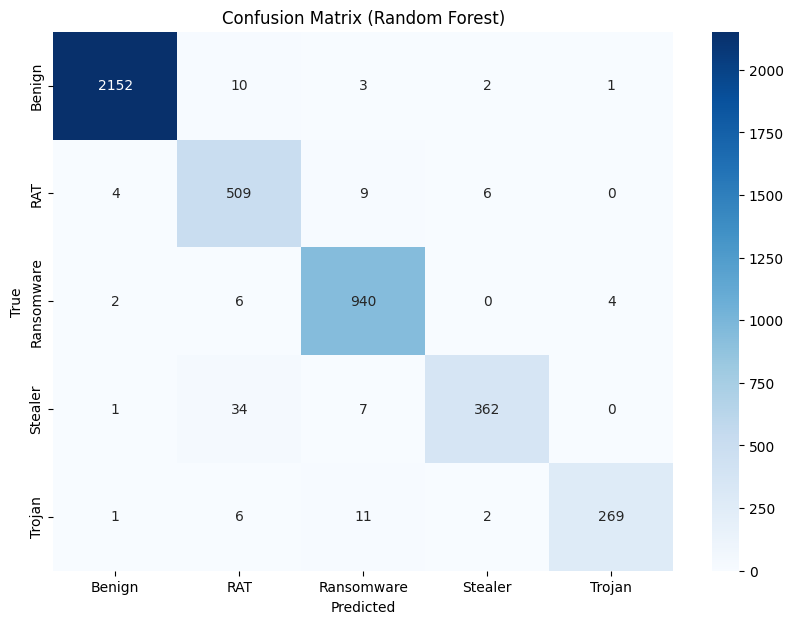


🔹 Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:46:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Performance:
  Accuracy:  0.9804
  Precision: 0.9807
  Recall:    0.9804
  F1-score:  0.9805

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      0.99      1.00      2168
         RAT       0.93      0.96      0.95       528
  Ransomware       0.98      0.99      0.98       952
     Stealer       0.97      0.93      0.95       404
      Trojan       0.99      0.96      0.97       289

    accuracy                           0.98      4341
   macro avg       0.97      0.97      0.97      4341
weighted avg       0.98      0.98      0.98      4341



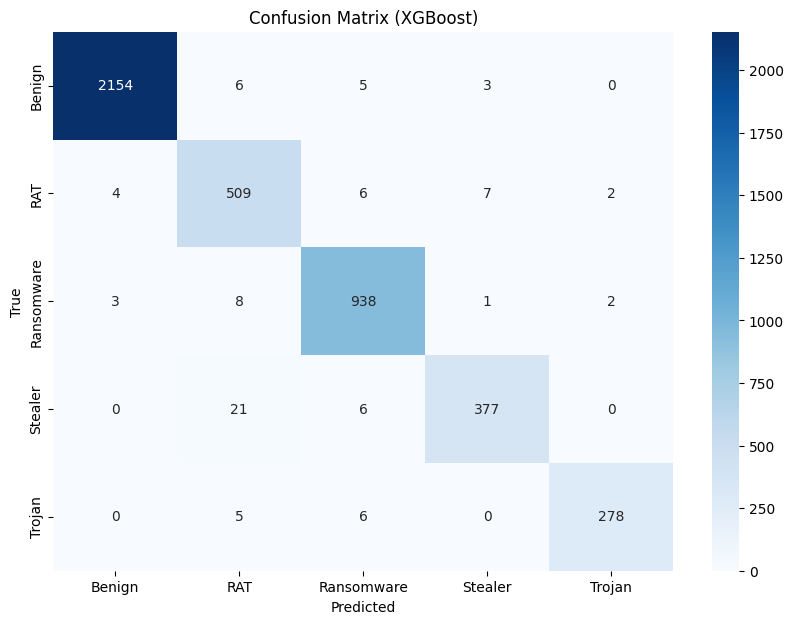


🔹 Training SVM...
SVM Performance:
  Accuracy:  0.9477
  Precision: 0.9479
  Recall:    0.9477
  F1-score:  0.9476

Classification Report:
               precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      2168
         RAT       0.84      0.88      0.86       528
  Ransomware       0.95      0.96      0.95       952
     Stealer       0.90      0.83      0.87       404
      Trojan       0.92      0.88      0.90       289

    accuracy                           0.95      4341
   macro avg       0.92      0.91      0.91      4341
weighted avg       0.95      0.95      0.95      4341



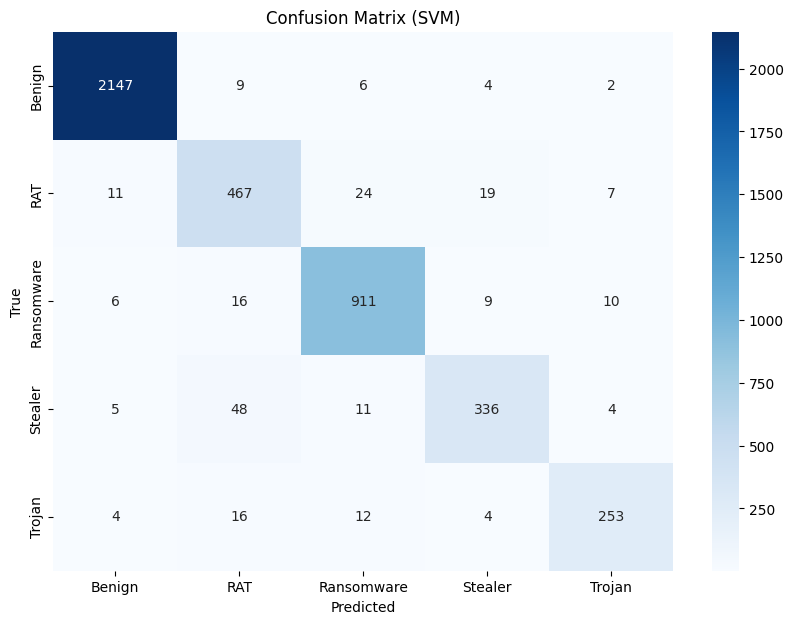


🔹 Training KNN...
KNN Performance:
  Accuracy:  0.9212
  Precision: 0.9204
  Recall:    0.9212
  F1-score:  0.9205

Classification Report:
               precision    recall  f1-score   support

      Benign       0.96      0.97      0.96      2168
         RAT       0.83      0.80      0.82       528
  Ransomware       0.92      0.95      0.93       952
     Stealer       0.85      0.82      0.84       404
      Trojan       0.91      0.84      0.88       289

    accuracy                           0.92      4341
   macro avg       0.89      0.88      0.88      4341
weighted avg       0.92      0.92      0.92      4341



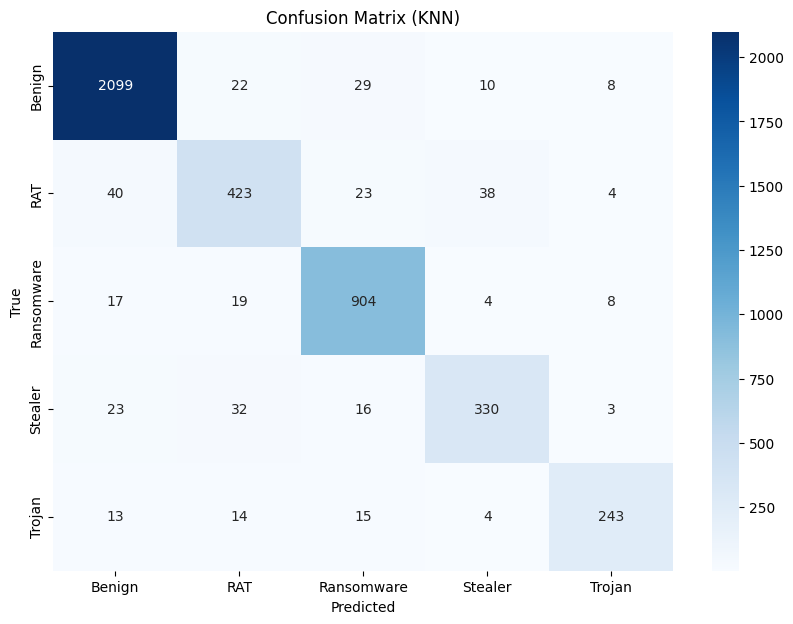


📊 Final Comparison:
                      Accuracy  Precision    Recall  F1-score
Logistic Regression  0.870537   0.871392  0.870537  0.870886
Random Forest        0.974891   0.975596  0.974891  0.974899
XGBoost              0.980419   0.980689  0.980419  0.980458
SVM                  0.947708   0.947943  0.947708  0.947578
KNN                  0.921216   0.920362  0.921216  0.920537


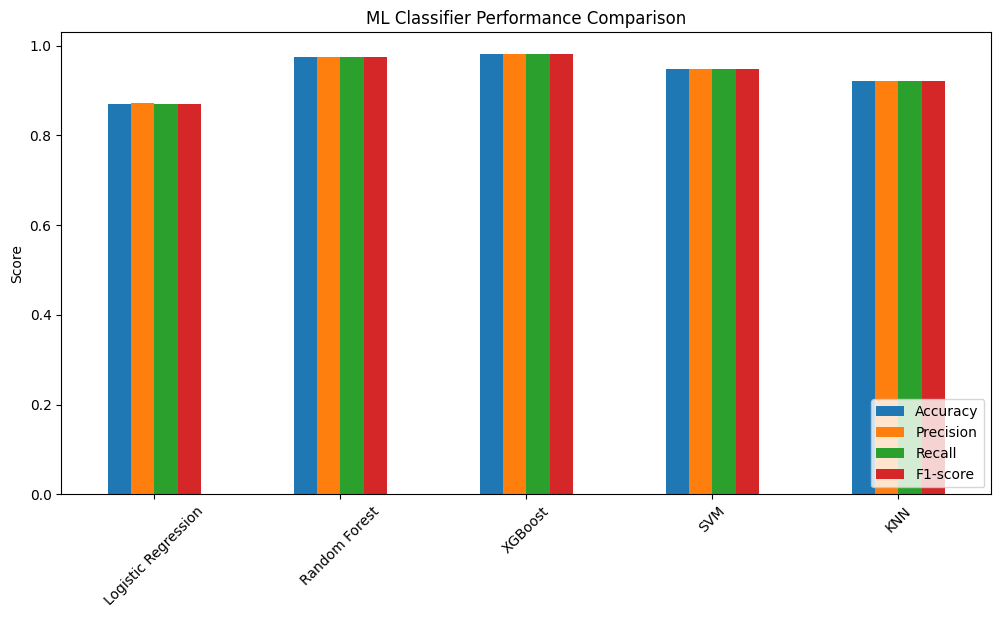

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# ML Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Feature scaling (important for SVM, KNN, LR)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# =====================================
# Define Models
# =====================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7)
}

results = {}

# =====================================
# Train & Evaluate
# =====================================
for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-score": f1}

    print(f"{name} Performance:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    #print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=encoder.classes_.astype(str)))
    # Define your two class names
    class_names = ["Benign", "RAT", "Ransomware", "Stealer", "Trojan"]

    print("\nClassification Report:\n", classification_report(
        y_test,
        y_pred,
        target_names=class_names
    ))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f"Confusion Matrix ({name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"/content/drive/MyDrive/ML/Thesis/Dataset/Graphs/Models/category-ml-{name}.pdf")   # <-- save as PDF
    plt.show()

# =====================================
# Compare Results
# =====================================
results_df = pd.DataFrame(results).T
print("\n📊 Final Comparison:\n", results_df)

# Bar Plot Comparison
results_df.plot(kind="bar", figsize=(12,6))
plt.title("ML Classifier Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.savefig("/content/drive/MyDrive/ML/Thesis/Dataset/Graphs/Models/category-ml-compare.pdf")   # <-- save as PDF
plt.show()
